## Лабораторная работа №4
**Тема:** BERT и Text classification

**Выполнил:** Студент группы БВТ2201 Шамсутдинов Рустам Фаргатевич

**Цель лабораторной работы:** Дообучить модель с архитектурой BERT для классификации текста на токсичный и не токсичный

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    auc,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from torch import amp
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer


In [4]:
df = pd.read_csv("russian_toxic_comments.csv")
print(df.shape)
print(df["toxic"].value_counts())


(14412, 2)
toxic
0.0    9586
1.0    4826
Name: count, dtype: int64


In [5]:
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["toxic"])
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, stratify=train_val_df["toxic"]
)

print(f"Samples — train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

Samples — train: 10376, val: 1153, test: 2883


In [6]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
MAX_LEN = 128
BATCH_SIZE = 32


class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc.input_ids.squeeze(0),  # [max_len]
            "attention_mask": enc.attention_mask.squeeze(0),  # [max_len]
            "label": torch.tensor(label, dtype=torch.float),  # 0.0 / 1.0
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [8]:
train_loader = DataLoader(
    ToxicDataset(train_df["comment"], train_df["toxic"], tokenizer),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)
val_loader = DataLoader(
    ToxicDataset(val_df["comment"], val_df["toxic"], tokenizer),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    ToxicDataset(test_df["comment"], test_df["toxic"], tokenizer),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

In [ ]:
class ToxicBERT(nn.Module):
    def __init__(self, dropout: float = 0.3, freeze_base: bool = True):
        super().__init__()
        # Загружаем Bert с pooler’ом
        self.bert = AutoModel.from_pretrained(
            "ai-forever/ruBert-base", add_pooling_layer=True
        )
        # Замораживаем все базовые слои, кроме последних 2 и pooler
        if freeze_base:
            for name, param in self.bert.named_parameters():
                # encoder.layer.10 и encoder.layer.11 — последние два слоя
                if not (
                    name.startswith("encoder.layer.10")
                    or name.startswith("encoder.layer.11")
                    or name.startswith("pooler")
                ):
                    param.requires_grad = False

        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        # Двухступенчатый классификатор
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, input_ids, attention_mask):
        # outputs.pooler_output — [batch_size, hidden_size]
        pooled = self.bert(
            input_ids=input_ids, attention_mask=attention_mask
        ).pooler_output
        x = self.dropout(pooled)
        logits = self.classifier(x).squeeze(-1)  # [batch_size]
        return logits

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"используется device = {device}")
model = ToxicBERT().to(device)

# балансировка классов
pos = train_df["toxic"].sum()
neg = len(train_df) - pos
pos_weight = torch.tensor([neg / pos], device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scaler = amp.GradScaler("cuda")


используется device = cuda


In [12]:
def evaluate(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            lbls = batch["label"].cpu().numpy()
            logits = model(ids, mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys.extend(lbls)
            ps.extend(probs)
    ys = np.array(ys)
    ps = np.array(ps)
    acc = accuracy_score(ys, ps > 0.5)
    f1 = f1_score(ys, ps > 0.5)
    roc_auc = roc_auc_score(ys, ps)
    prec, rec, _ = precision_recall_curve(ys, ps)
    pr_auc = auc(rec, prec)
    return acc, f1, roc_auc, pr_auc

In [ ]:
NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_losses = []
    loop = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch in loop:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        lbls = batch["label"].to(device)

        optimizer.zero_grad()

        with amp.autocast("cuda"):
            logits = model(ids, mask)
            loss = criterion(logits, lbls)

        # Масштабирование и шаг оптимизатора
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_losses.append(loss.item())
        loop.set_postfix(train_loss=np.mean(epoch_losses))

    val_acc, val_f1, val_roc, val_pr = evaluate(val_loader)
    print(
        f"→ Epoch {epoch} | val acc: {val_acc:.4f} | F1: {val_f1:.4f} "
        f"| ROC-AUC: {val_roc:.4f} | PR-AUC: {val_pr:.4f}"
    )

Epoch 1:   0%|          | 0/325 [00:00<?, ?it/s]

→ Epoch 1 | val acc: 0.9046 | F1: 0.8675 | ROC-AUC: 0.9714 | PR-AUC: 0.9415


Epoch 2:   0%|          | 0/325 [00:00<?, ?it/s]

→ Epoch 2 | val acc: 0.8820 | F1: 0.8447 | ROC-AUC: 0.9721 | PR-AUC: 0.9430


Epoch 3:   0%|          | 0/325 [00:00<?, ?it/s]

→ Epoch 3 | val acc: 0.9072 | F1: 0.8677 | ROC-AUC: 0.9705 | PR-AUC: 0.9423


Epoch 4:   0%|          | 0/325 [00:00<?, ?it/s]

→ Epoch 4 | val acc: 0.9072 | F1: 0.8677 | ROC-AUC: 0.9690 | PR-AUC: 0.9376


Epoch 5:   0%|          | 0/325 [00:00<?, ?it/s]

→ Epoch 5 | val acc: 0.9089 | F1: 0.8733 | ROC-AUC: 0.9685 | PR-AUC: 0.9264


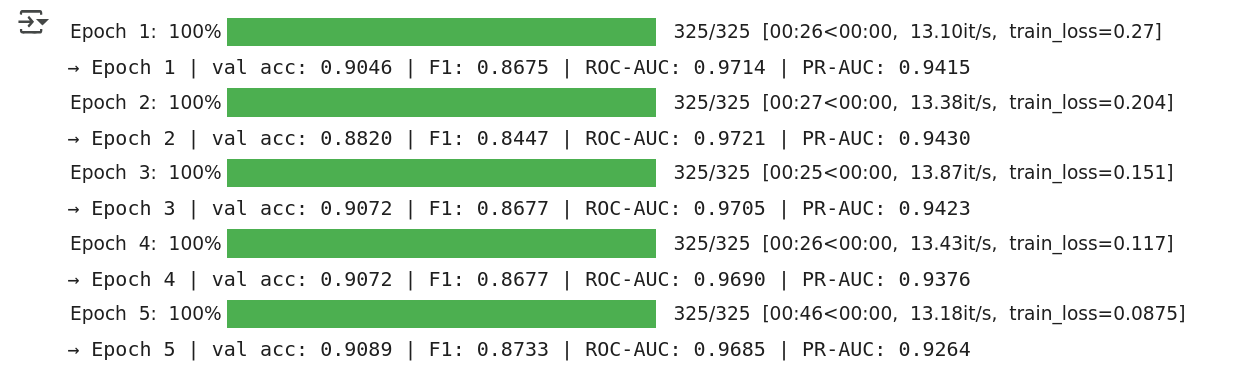

In [15]:
test_acc, test_f1, test_roc, test_pr = evaluate(test_loader)
print("\n=== FINAL TEST METRICS ===")
print(
    f"Acc: {test_acc:.4f} | F1: {test_f1:.4f} | "
    f"ROC-AUC: {test_roc:.4f} | PR-AUC: {test_pr:.4f}"
)


=== FINAL TEST METRICS ===
Acc: 0.9220 | F1: 0.8882 | ROC-AUC: 0.9682 | PR-AUC: 0.9378


In [ ]:
MAX_LEN = 128  # то же, что при обучении


def predict_one(text: str):
    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt",
    )

    input_ids = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, mask)
        prob = torch.sigmoid(logits).item()
        label = 1 if prob > 0.5 else 0

    return label, prob


text1 = "Ты дурак!"
label, confidence = predict_one(text1)
print(f"Text: «{text1}»  →  Toxic? {label}  (p={confidence:.3f})")

text2 = "Спасибо за помощь."
label, confidence = predict_one(text2)
print(f"Text: «{text2}»  →  Toxic? {label}  (p={confidence:.3f})")


text3 = "да да да ты очень умный!"
label, confidence = predict_one(text3)
print(f"Text: «{text3}»  →  Toxic? {label}  (p={confidence:.3f})")


Text: «Ты дурак!»  →  Toxic? 1  (p=0.998)
Text: «Спасибо за помощь.»  →  Toxic? 0  (p=0.001)
Text: «да да да ты очень умный!»  →  Toxic? 1  (p=0.989)


In [18]:
torch.save(model.state_dict(), "ToxicBERT")

In [ ]:
model = ToxicBERT()
model.load_state_dict(torch.load("ToxicBERT", weights_only=True))
model.eval()

ToxicBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af